<a href="https://colab.research.google.com/github/MaeenMo/Computer-Vision-Barcode-Reader/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Requirements**

In [ ]:
# !pip install opencv-python
# !pip install matplotlib

# **Mount Drive**

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
omarVar = "/content"
maeenVar = "/content/drive/MyDrive/Colab Notebooks/Vision"

# **Barcode Reader**

## Import Libraries

cv2 is the OpenCV library in Python, which stands for Open Source Computer Vision Library. It's a powerful tool for computer vision tasks and image processing. Here are some reasons why we use cv2:
* Image Loading and Saving: OpenCV allows you to read images from files and save processed images back to files.
* Image Preprocessing: It provides various functions for image preprocessing, such as blurring, thresholding, and noise reduction.
* Feature Detection: OpenCV includes algorithms for detecting features like edges, contours, and keypoints.
* Geometric Transformations: You can perform operations like rotation, scaling, and translation on images.
* Object Detection: OpenCV supports object detection techniques, including face detection and barcode detection.
* Video Processing: It can handle video capture and processing, making it useful for real-time applications.

numpy is a fundamental package for scientific computing in Python. Here are some reasons why we use numpy (imported as np for convenience):
* Efficient Array Operations: numpy provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently.
* Performance: Operations using numpy are generally faster than using Python's built-in lists due to its optimized C implementation.
* Linear Algebra: It includes functions for linear algebra, Fourier transform, and random number generation, which are essential for many computer vision tasks.
* Integration: numpy integrates well with other libraries like OpenCV (cv2), making it easier to perform complex image processing tasks.
*Convenience: It simplifies many operations, such as element-wise operations, reshaping, and broadcasting, which are common in image processing.

matplotlib.pyplot (imported as plt) is a plotting library in Python that is widely used for creating static, animated, and interactive visualizations. Here are some reasons why we use matplotlib.pyplot:
* Visualization: It allows you to visualize data in various forms, such as line plots, scatter plots, histograms, and more. This is crucial for understanding and interpreting data.
* Debugging: Visualizing intermediate steps in image processing helps in debugging and fine-tuning algorithms. For example, you can see the effects of preprocessing steps like blurring, thresholding, and edge detection.
* Presentation: It helps in creating clear and informative plots for presentations and reports, making it easier to communicate your findings.
* Customization: matplotlib.pyplot offers extensive customization options for plots, including titles, labels, legends, and color schemes, allowing you to create professional-quality visualizations.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

## Barcode Functions

### Plot Images

In [ ]:
def plot_images(img,title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()
def plot_images_fig(img,ax,title):
    ax.set_title(title)
    ax.imshow(img, cmap="gray")
    ax.axis("off")


### Plot Contour

In [ ]:
def plot_contours(img,title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

### Plot Histogram

In [ ]:
def plot_histogram(image, ax, title):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    ax.plot(hist)
    ax.set_title(title)
    ax.set_xlim([0, 256])
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")


### Crop Barcode

In [ ]:
def crop_barcode(image, tcName):
    # Step 1: Binarize the image
    _, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    # Binarized Image
    plot_images(binary,"Phase 2: Binarized Image")

    # Step 2: Morphological closing with a larger kernel to merge barcode lines
    # Bar Width is 8 pixels & Gap between bars & Numbers is 13 pixels
    # Hence width > 8 (35) & height > 13 (35) For thin numbers font
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35, 35))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Morphological Closing
    plot_images(closed,"Phase 3: Morphological Closing")

    # Find contours
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Contour Drawing
    contoured_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color for drawing
    cv2.drawContours(contoured_image, contours, -1, (0, 0, 255), 2)  # Red color for contours

    plot_contours(contoured_image,"Phase 4: Contour Drawing")

    # Initialize variables to find the largest bounding box
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
    found = False

    # Loop through contours
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = w / float(h)

        # Adjusted criteria for detection
        if w > 100 and h > 50 and aspect_ratio > 1.5:
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)
            found = True

    # Detected Contours with Bounding Box
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color for rectangle
    if found:
        # gap size + numbers height / total height = (34 + 13) / 247 = 19.03%
        # We chose percentage to be generic when scaling barcode image
        height_adjustment = int((y_max - y_min) * 0.1903)  # Exclude bottom 19.03%
        y_max -= height_adjustment
        cv2.rectangle(output, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    plot_contours(output,"Phase 5: Detected Contours with Bounding Box")

    # Cropped Barcode
    if found:
        cropped_image = image[y_min:y_max, x_min:x_max]

        plot_images(cropped_image,"Phase 6: Cropped Barcode")

        # To save cropped image
        # save_path = f"{omarVar}/Output/{tcName}_cropped_barcode.jpg"
        # cv2.imwrite(save_path, cropped_image)
        # save_path = f"{maeenVar}/Output/{tcName}_cropped_barcode.jpg"
        # cv2.imwrite(save_path, cropped_image)
        # print(f"Cropped barcode saved at: {save_path}")
    else:
        print("No bounding box found for cropping!")

    return cropped_image

## **TC1: Recognize Centered Barcode**

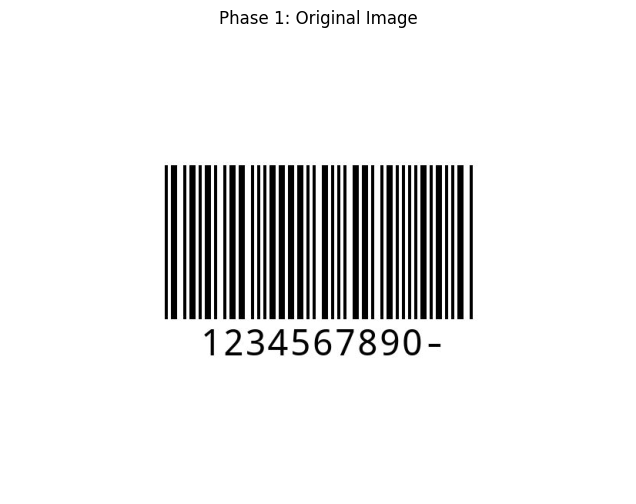

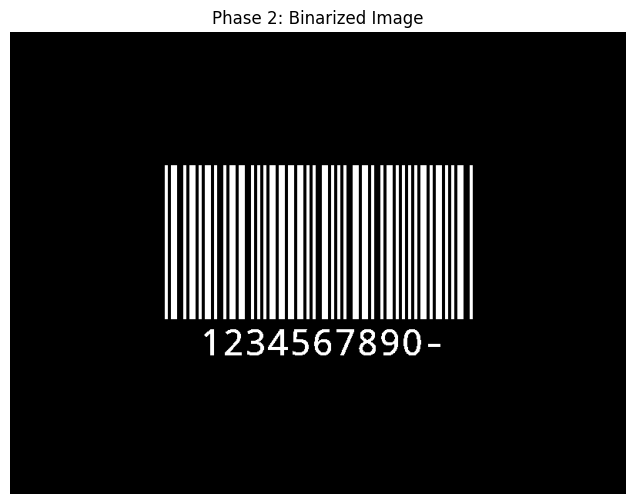

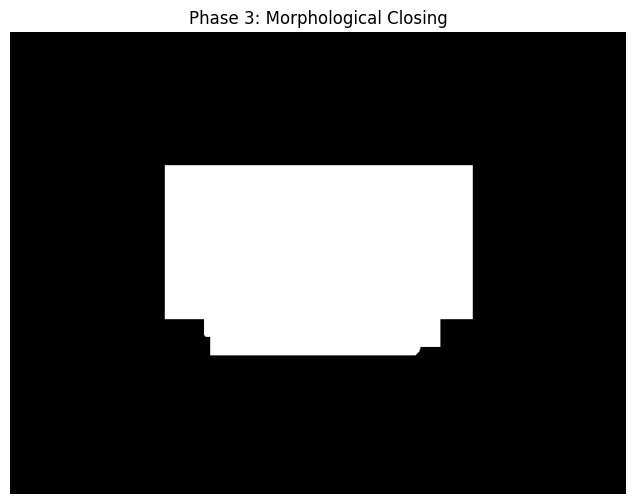

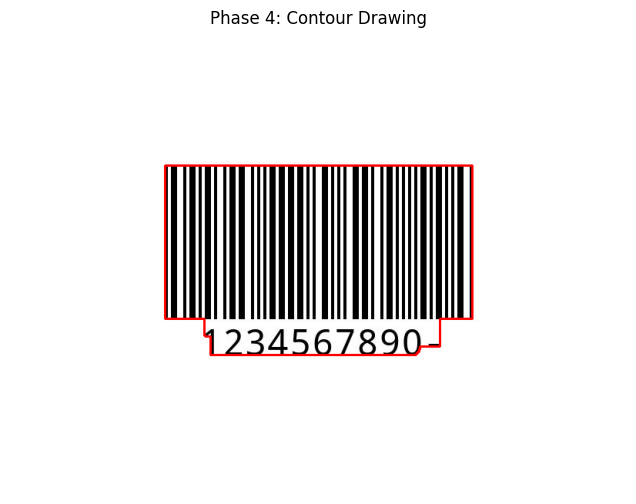

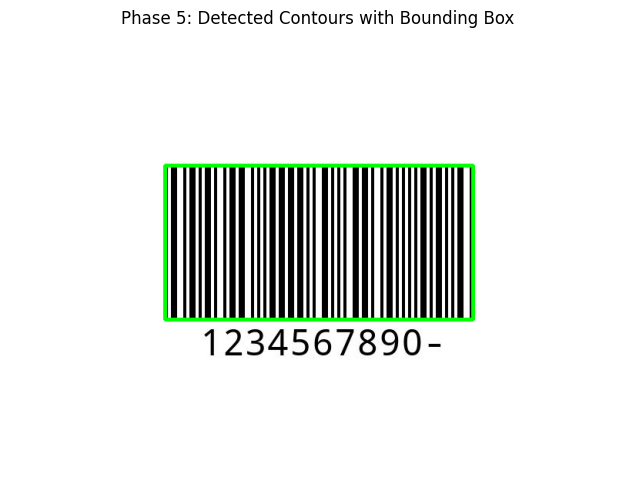

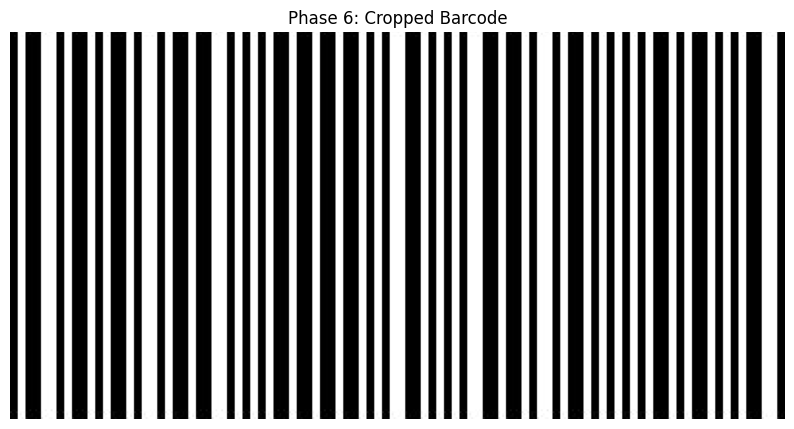

array([[ 0, 14,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  7,  0],
       [ 1,  0, 14, ...,  0,  3,  0],
       ...,
       [ 0, 10,  0, ...,  0,  7,  2],
       [ 6,  3,  0, ...,  0, 13,  0],
       [ 0,  7,  5, ...,  0,  0,  0]], dtype=uint8)
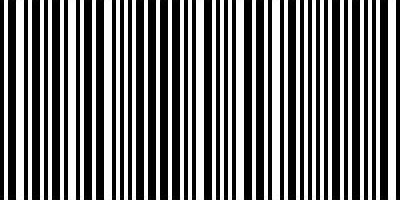

In [ ]:
image_path = f"{omarVar}/Test Cases/01 - lol easy.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Original Image
plot_images(image,"Phase 1: Original Image")
crop_barcode(image, "01 - lol easy")

## **TC2: Recognize Shifted Barcode**

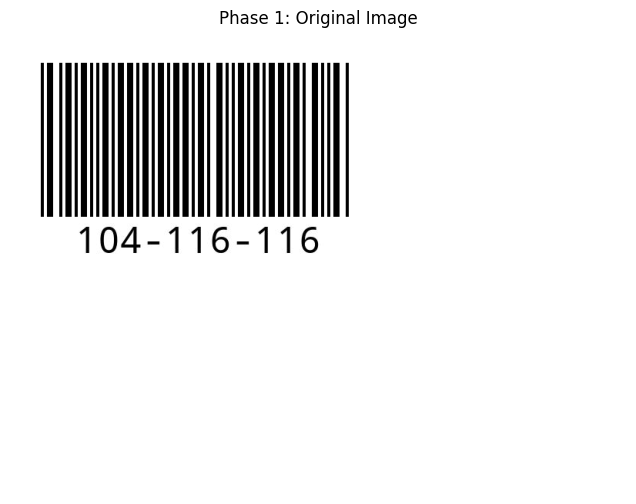

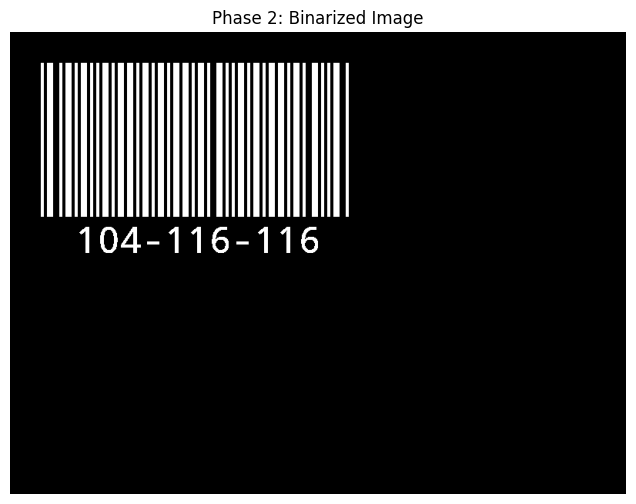

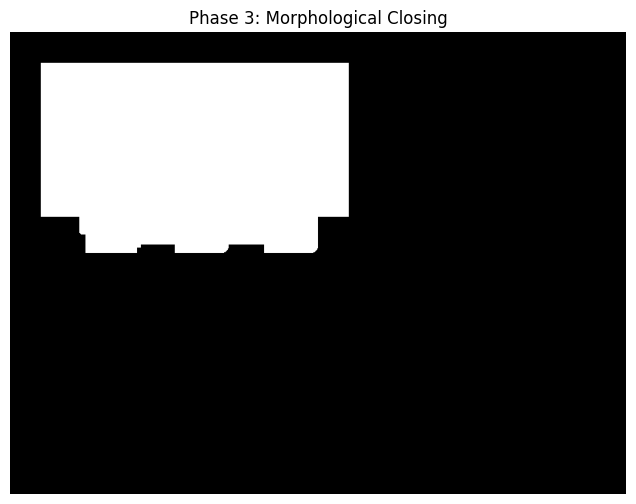

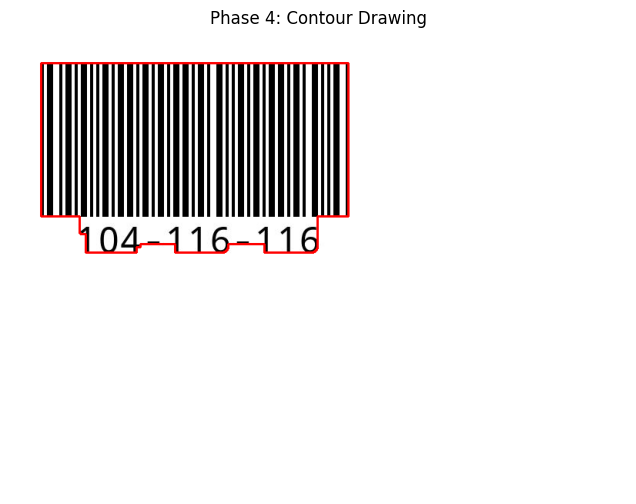

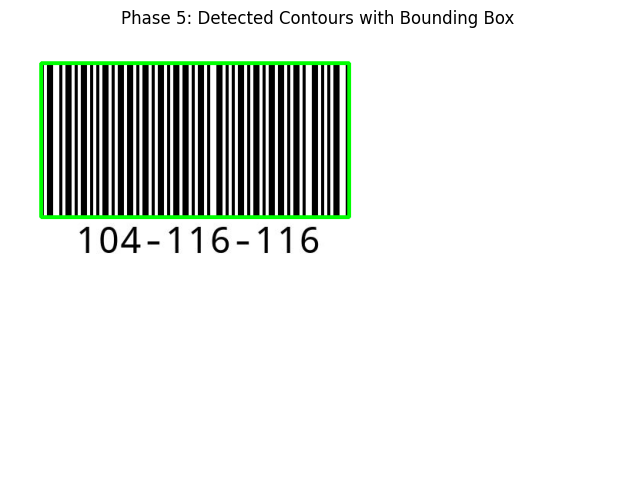

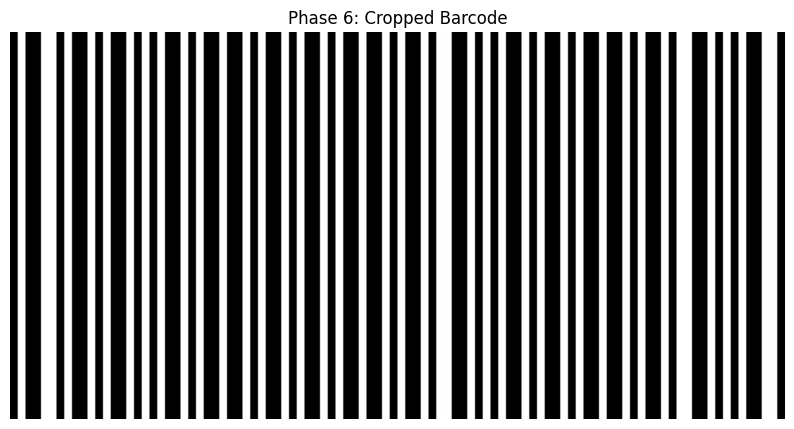

array([[0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]], dtype=uint8)
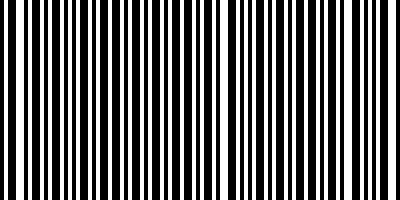

In [ ]:
image_path = f"{omarVar}/Test Cases/02 - still easy.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Original Image
plot_images(image,"Phase 1: Original Image")
crop_barcode(image, "02 - still easy")

## **TC 4: Recognize Blurred Barcode**

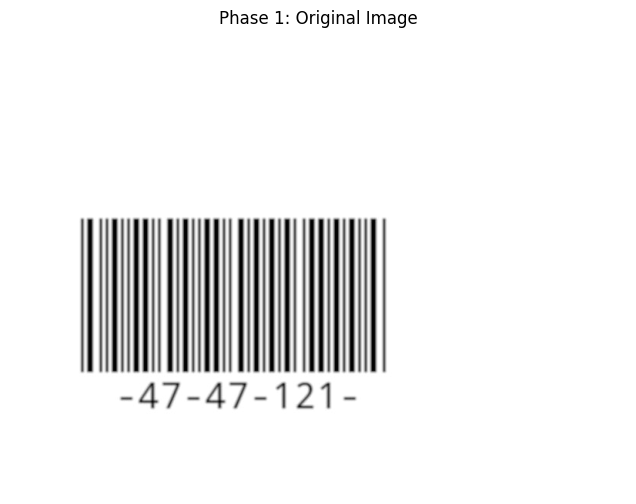

Mean Difference: 4.141029166666667
Image is blurred. Applying sharpening...


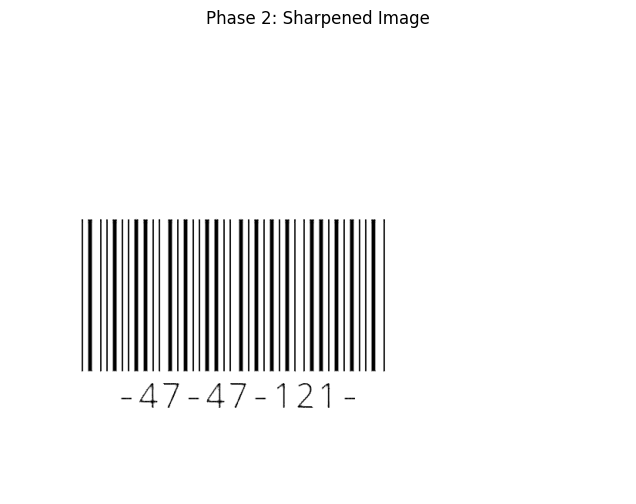

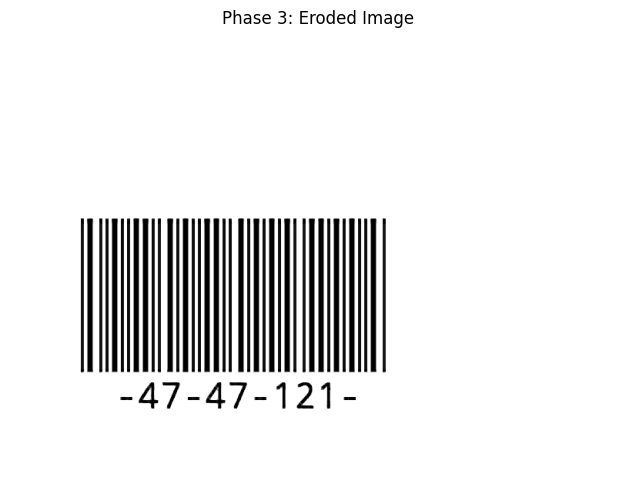

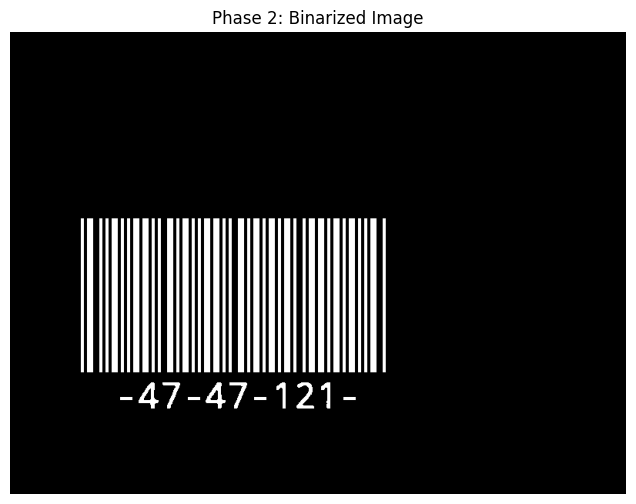

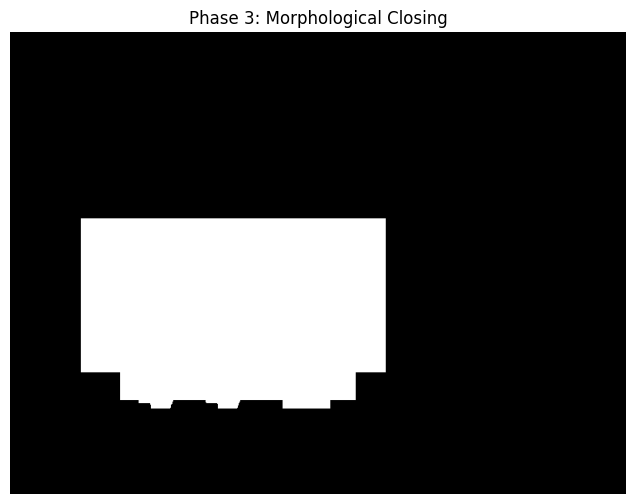

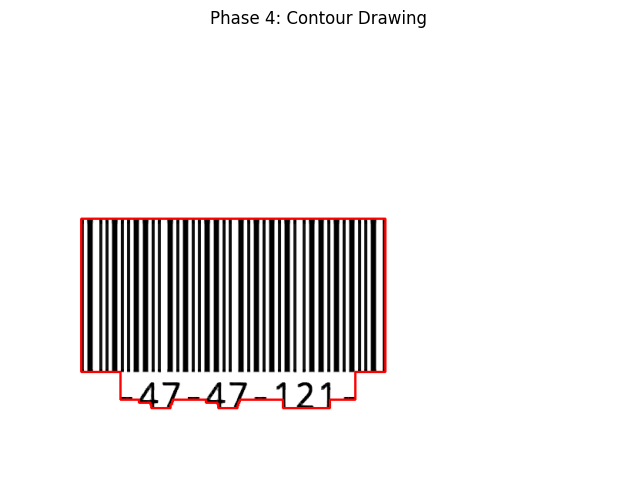

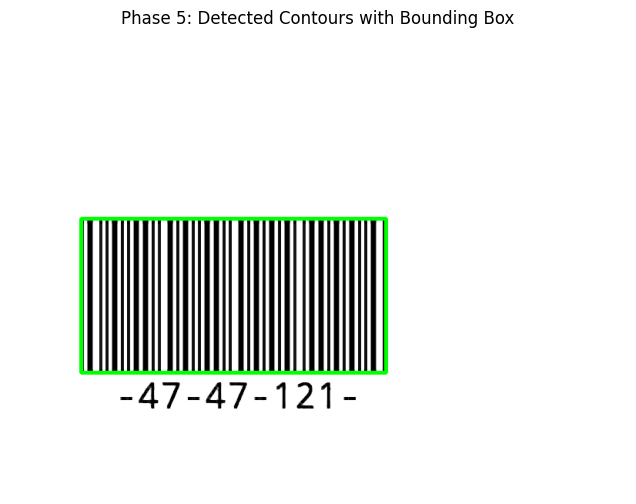

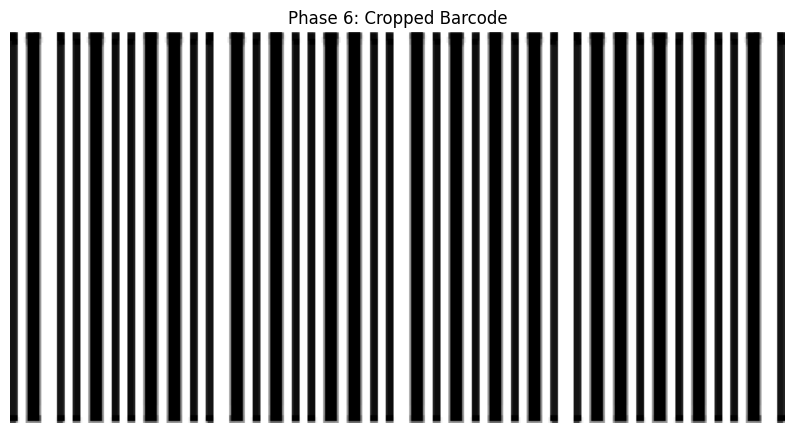

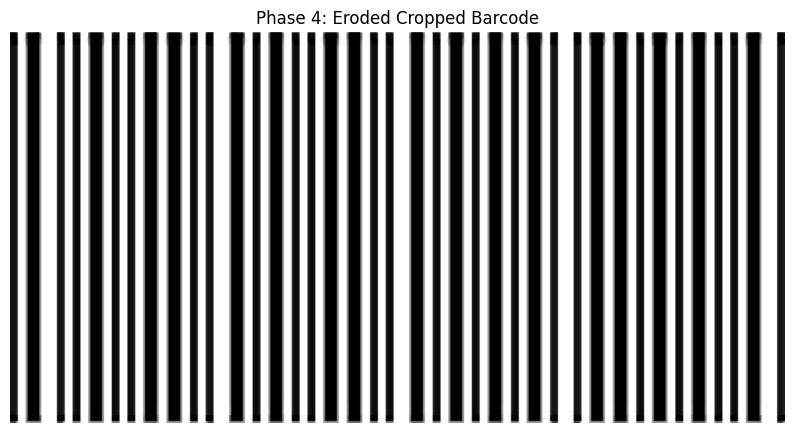

True

In [ ]:
# For threshold = 5, is suitable with medium resolution images,
# But if there high resolution image with low blur intensity,
# We need to increase the threshold to 10 or 15
# --------------------------------------------------------------
# For kernel size of (5 x 5) to catch high blur intensities,
# But can use (7 x 7) or (9 x 9) but will take more computations
def is_blurred(image, threshold=5.0, kernel_size=(5, 5)):
    # Step 1: Apply an average filter (smoothing)
    blurred_image = cv2.blur(image, kernel_size)

    # Step 2: Compute the absolute difference between the original and blurred image
    difference = cv2.absdiff(image, blurred_image)

    # Step 3: Compute the mean of the difference
    mean_difference = np.mean(difference)
    print(f"Mean Difference: {mean_difference}")

    # Step 4: Compare the mean difference with the threshold
    return mean_difference < threshold

# Function to sharpen an image
def sharpen_image(image):
    # Step 1: Apply the Laplacian filter
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Step 2: Convert Laplacian back to the same data type as the original image
    laplacian = np.uint8(np.absolute(laplacian))

    # Step 3: Sharpen by adding the Laplacian to the original image (Baseline)
    alpha = 2 # Weight multiplied by original image
    beta = -2 # Weight multiplied by laplacian image
    sharpened = cv2.addWeighted(image, alpha, laplacian, beta, 0)

    return sharpened

# Load the image
image_path = f"{omarVar}/Test Cases/04 - fen el nadara.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Original Image
plot_images(image,"Phase 1: Original Image")

# Check if the image is blurred
if is_blurred(image, threshold=5.0, kernel_size=(5, 5)):
    print("Image is blurred. Applying sharpening...")
    image = sharpen_image(image)
    # Phase 2: Sharpened Image
    plot_images(image,"Phase 2: Sharpened Image")
else:
    print("Image is not blurred. Proceeding...")

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Adjust kernel size if needed
eroded_image = cv2.erode(image, kernel, iterations=1)
plot_images(eroded_image,"Phase 3: Eroded Image")

cropped_eroded_image = crop_barcode(eroded_image, "04 - fen el nadara")

plot_images(cropped_eroded_image,"Phase 4: Eroded Cropped Barcode")
save_path = f"{omarVar}/Output/04 - fen el nadara_eroded_cropped_barcode.jpg"
cv2.imwrite(save_path, cropped_eroded_image)

## **TC 5 & 6: Recognize Darken & Brighten Barcodes**

Left non-zero pixel intensity: 0
Right non-zero pixel intensity: 21
Midpoint: 10
Mean value: 13.4706375
Shift value: 116


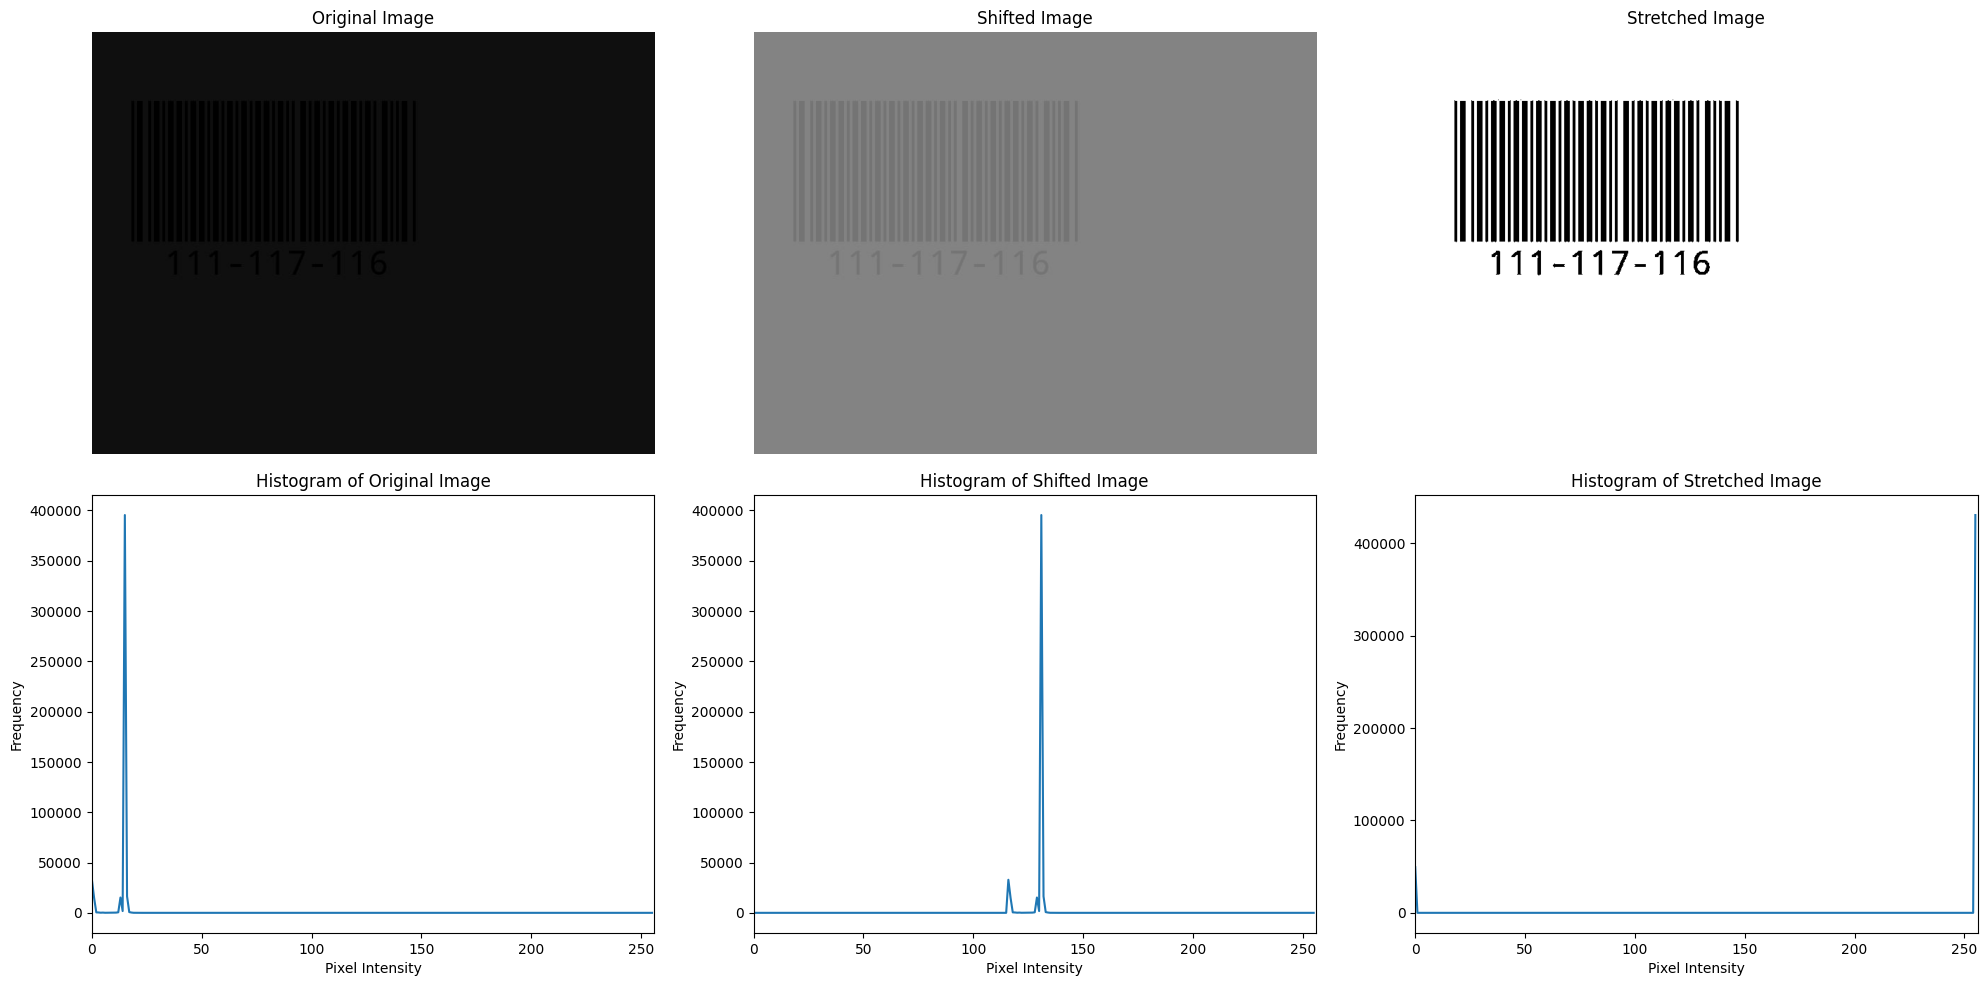

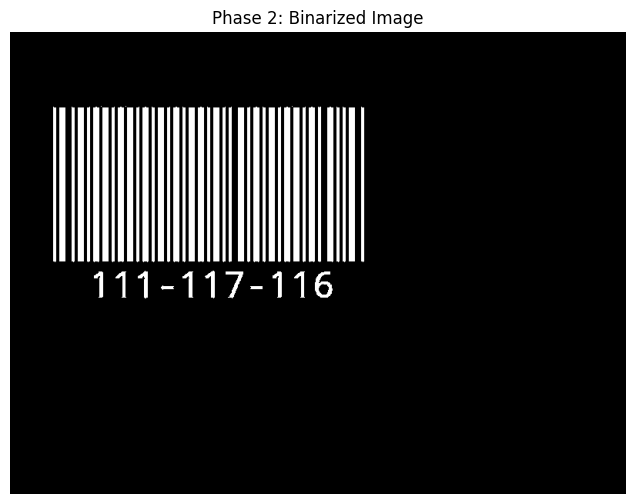

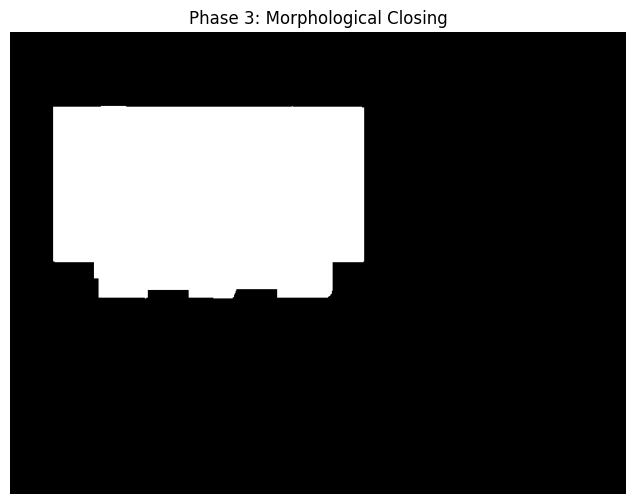

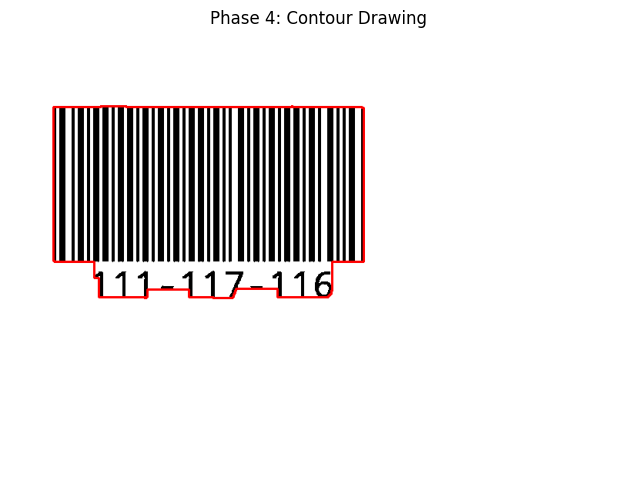

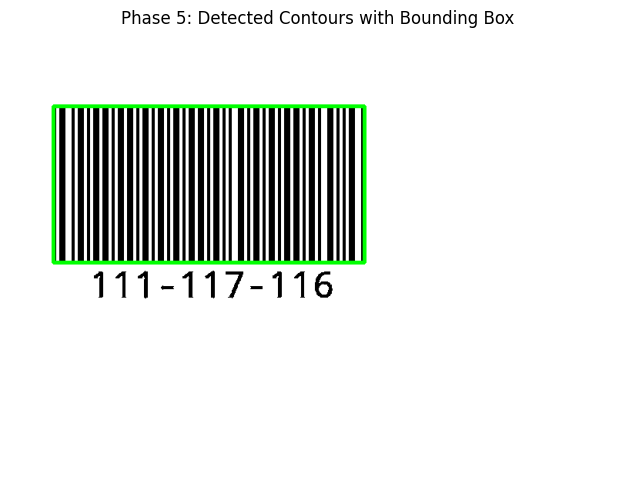

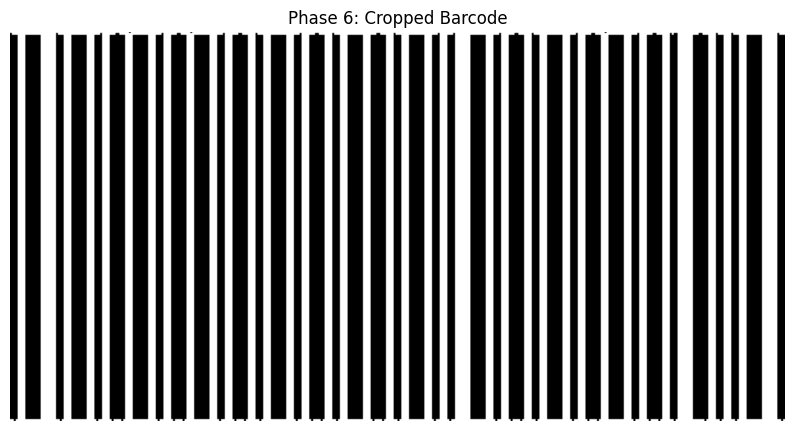

In [ ]:
def shift_histogram_to_middle(image):
    # Calculate the mean of the image
    mean_val = np.mean(image)
    print(f"Mean value: {mean_val}")

    # Shift by midpoint of the histogram
    shift_value = 127 - math.floor((mean_val + midpoint)/2)
    print(f"Shift value: {shift_value}")

    # Shift the pixel values by the calculated amount
    image_shifted = image + shift_value

    # Clip the values to be within the valid range [0, 255]
    image_shifted = np.clip(image_shifted, 0, 255).astype(np.uint8)

    return image_shifted

def apply_threshold(image):
    # Set the threshold at 127 to classify pixels into black and white
    image[image < 127] = 0
    image[image >= 127] = 255
    return image

def calculate_histogram_midpoint(image):
    # Calculate the histogram of the image (grayscale)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel()

    # Find the first non-zero intensity from the left
    left = np.argmax(hist > 0)

    # Find the first non-zero intensity from the right
    right = len(hist) - 1 - np.argmax(hist[::-1] > 0)

    # Calculate the midpoint
    midpoint = (left + right) // 2
    return left, right, midpoint

# Load image
# Test Case 5
image_path = f"{maeenVar}/Test Cases/05 - meen taffa el nour!!!.jpg"
# image_path = f"{omarVar}/Test Cases/05 - meen taffa el nour!!!.jpg"

# Extreme Version of Test Case 5
# image_path = f"{maeenVar}/Test Cases/05 - meen taffa el nour!!!2.jpg"

# Test Case 6
# image_path = f"{maeenVar}/Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg"
# image_path = f"{omarVar}/Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg"

# Extreme Version of Test Case 6
# image_path = f"{maeenVar}/Test Cases/06 - meen fata7 el nour 333eenaaayy1.jpg"


image = cv2.imread(image_path) # Reading image without gray scale so it can be plotted correctly

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot original image
plot_images_fig(image,axes[0,0],"Original Image")

# Plot original histogram
plot_histogram(image, axes[1,0], "Histogram of Original Image")

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Get histogram midpoint
left, right, midpoint = calculate_histogram_midpoint(image)
print(f"Left non-zero pixel intensity: {left}")
print(f"Right non-zero pixel intensity: {right}")
print(f"Midpoint: {midpoint}")

# Shift histogram to the middle
shifted_image = shift_histogram_to_middle(image)

shifted_image = cv2.cvtColor(shifted_image, cv2.COLOR_GRAY2BGR)

# Plot shifted image
plot_images_fig(shifted_image,axes[0,1],"Shifted Image")

# Plot shifted image histogram
plot_histogram(shifted_image, axes[1, 1], "Histogram of Shifted Image")

shifted_image = cv2.cvtColor(shifted_image, cv2.COLOR_BGR2GRAY)
# Apply histogram stretching
stretched_image = apply_threshold(shifted_image)

stretched_image = cv2.cvtColor(stretched_image, cv2.COLOR_GRAY2BGR)
# Show stretched image
plot_images_fig(stretched_image,axes[0,2],"Stretched Image")

# Plot threshold image histogram
plot_histogram(stretched_image,axes[1,2],"Histogram of Stretched Image")

plt.tight_layout()
plt.show()

stretched_image = cv2.cvtColor(stretched_image, cv2.COLOR_BGR2GRAY)
cropped_shifted_image = crop_barcode(stretched_image,"05 - meen taffa el nour!!!")

# Save the adjusted image
# save_path = f"{omarVar}/Output/05 - meen taffa el nour!!!.jpg"
# cv2.imwrite(save_path, cropped_shifted_image)
save_path = f"{maeenVar}/Output/05 - meen taffa el nour!!!.jpg"
# cv2.imwrite(save_path, cropped_shifted_image)

## **TC 7: Recognize Salt & Pepper Barcode**


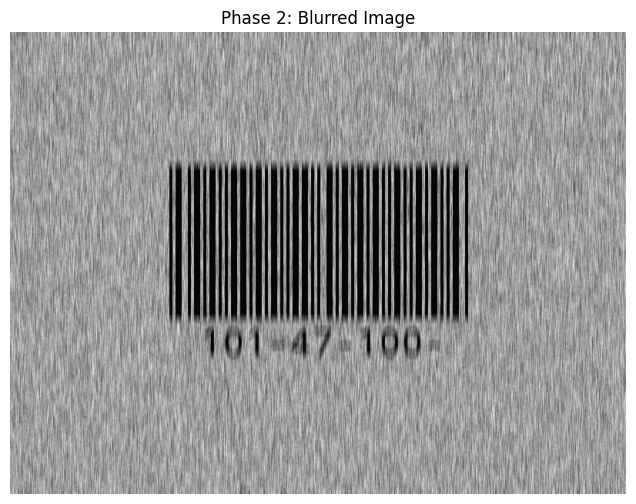

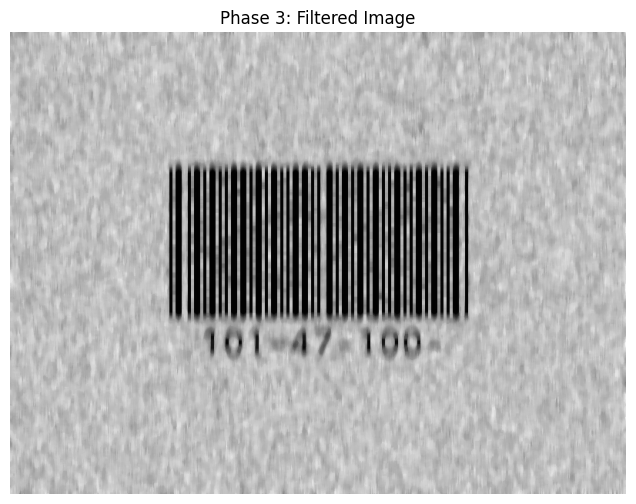

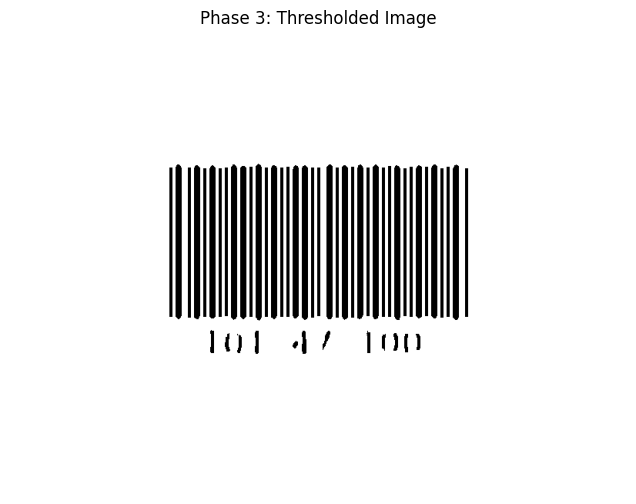

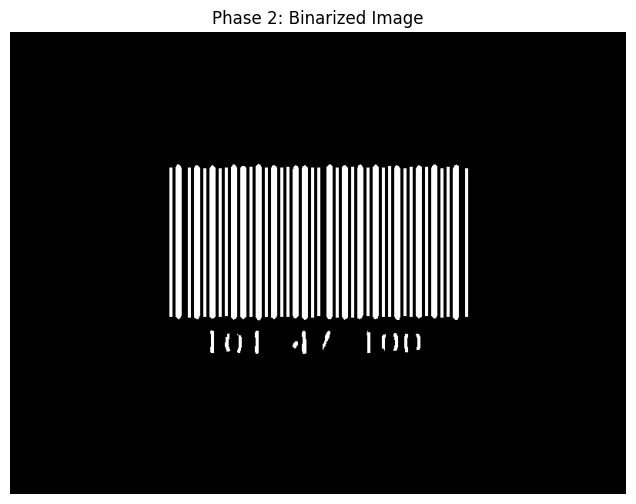

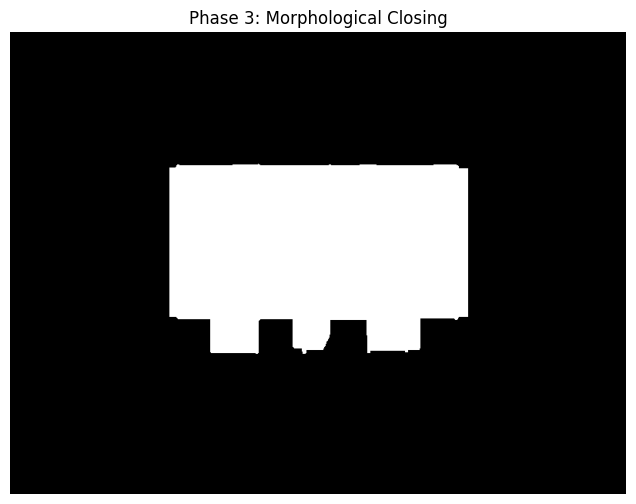

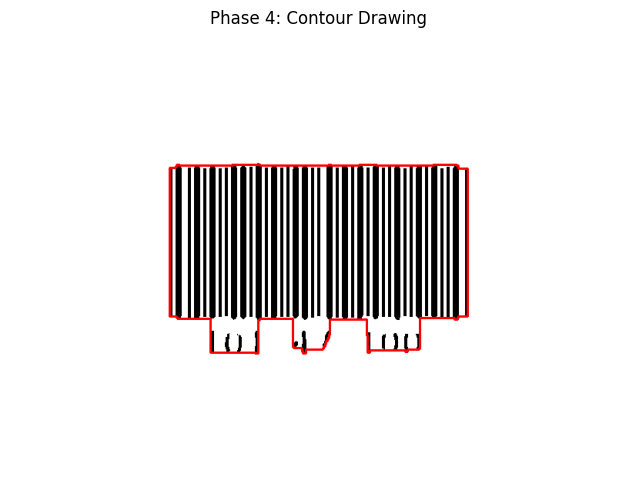

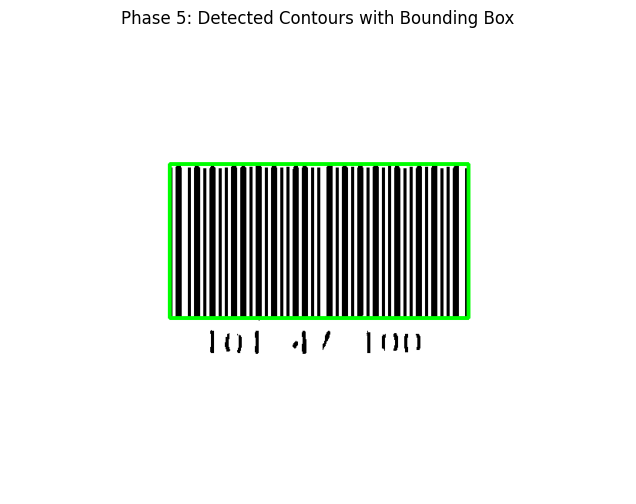

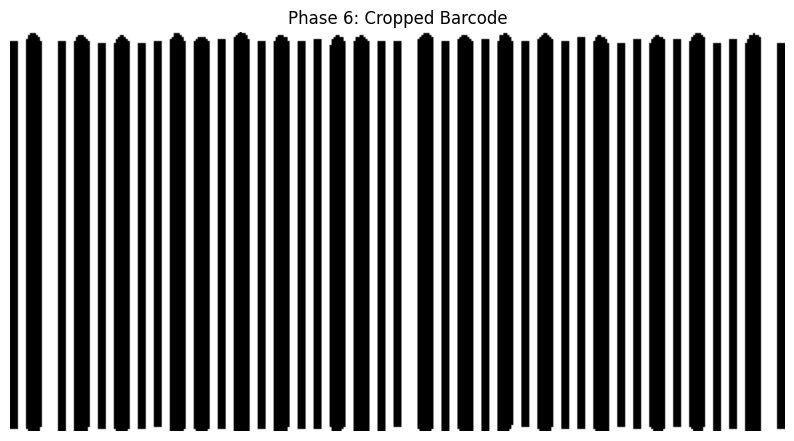

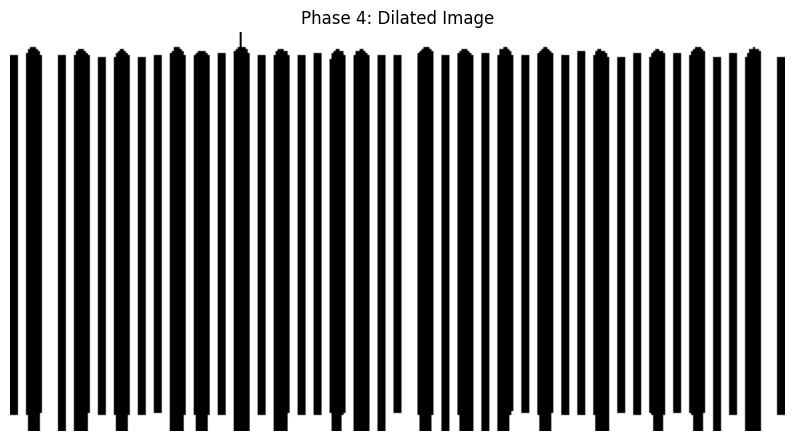

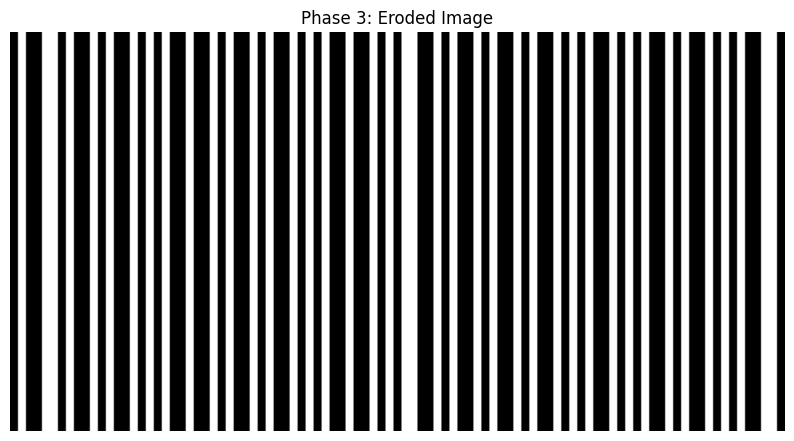

In [ ]:
image_path = f"{omarVar}/Test Cases/07 - mal7 w felfel.jpg"
# image_path = f"{maeenVar}/Test Cases/07 - mal7 w felfel.jpg"
# image_path = f"{maeenVar}/Test Cases/ml7 & flfl.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply a blur (15) to reduce small noise, preserving key details.
# Use a median filter (7) since the space between bars is 8 pixels, preserving bar structure while removing noise.
blur_image = cv2.blur(image, (1,15)) # Vertical kernel
plot_images(blur_image,"Phase 2: Blurred Image")
Filtered_Image = cv2.medianBlur(blur_image, 7)
plot_images(Filtered_Image,"Phase 3: Filtered Image")
_, image_threshold = cv2.threshold(Filtered_Image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_images(image_threshold,"Phase 3: Thresholded Image")

cropped_Filtered_Image = crop_barcode(image_threshold,"07 - mal7 w felfel")

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
dilated_image = cv2.dilate(cropped_Filtered_Image, kernel, iterations=1)
plot_images(dilated_image,"Phase 4: Dilated Image")
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 200)) # Using 1x200 structuring element because the bar code height is 200px, so the filter covers all the bar
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
plot_images(eroded_image,"Phase 3: Eroded Image")

## **TC 9: Detect Rotated Barcode**

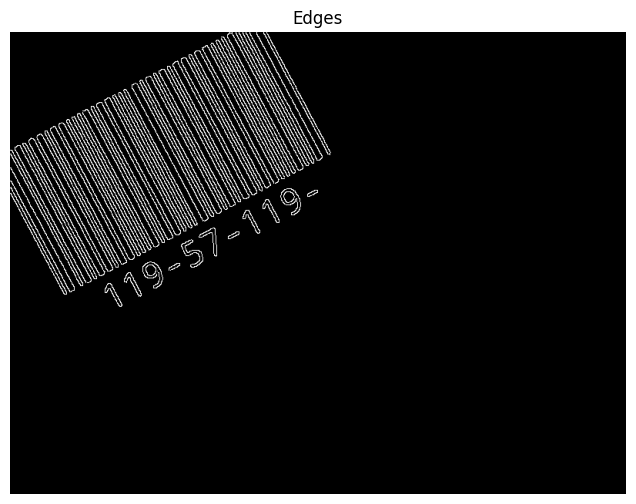

Detected Angle: 151.99998474121094
Adjusted Angle: -28.000015258789062
Detected rotation angle: -28.000015258789062 degrees


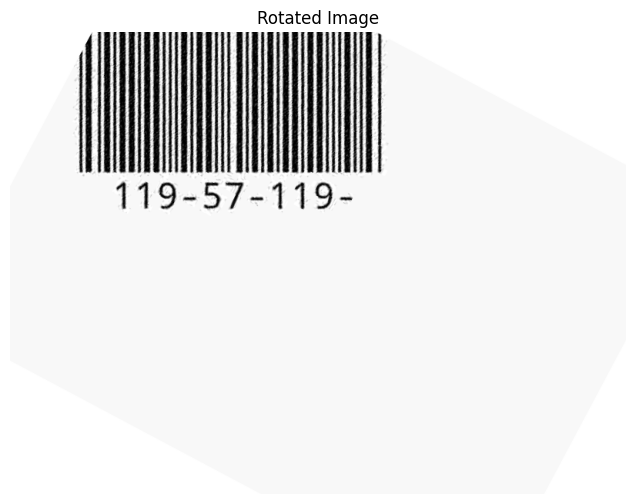

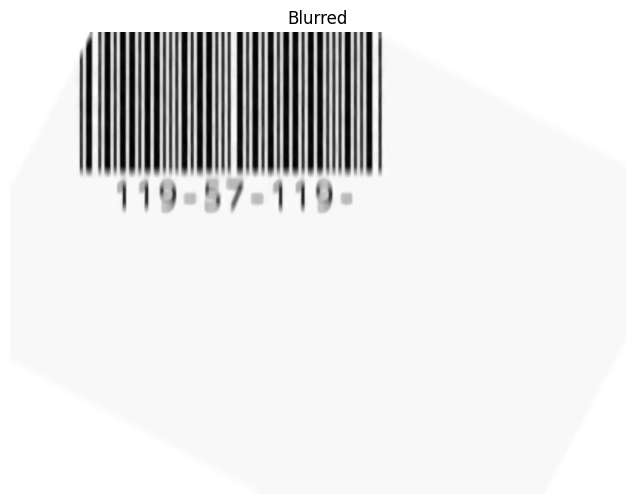

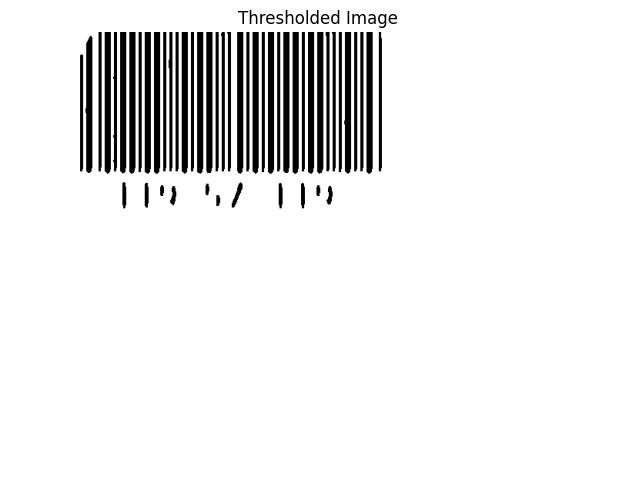

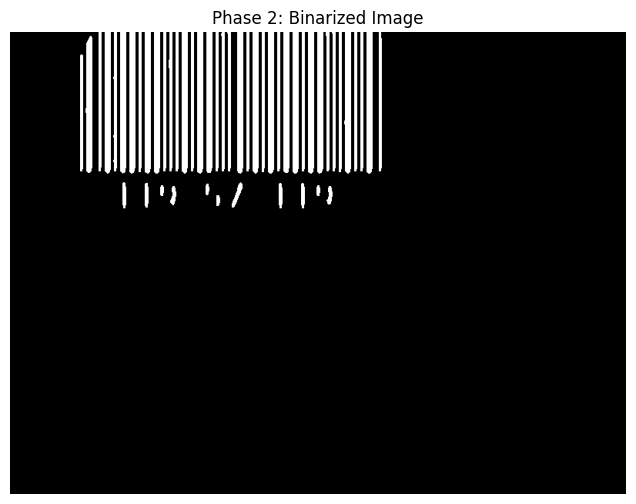

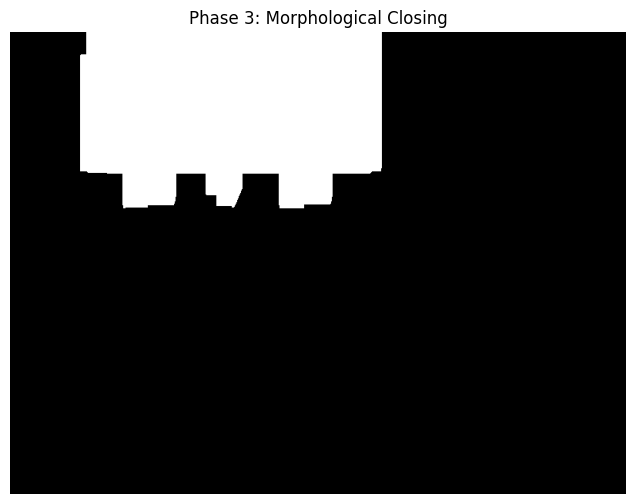

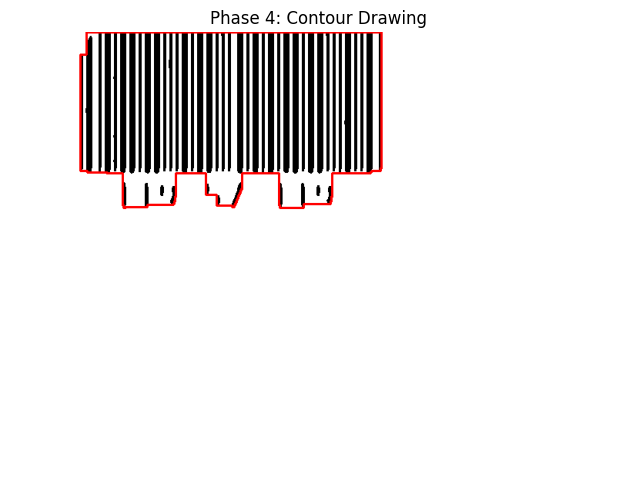

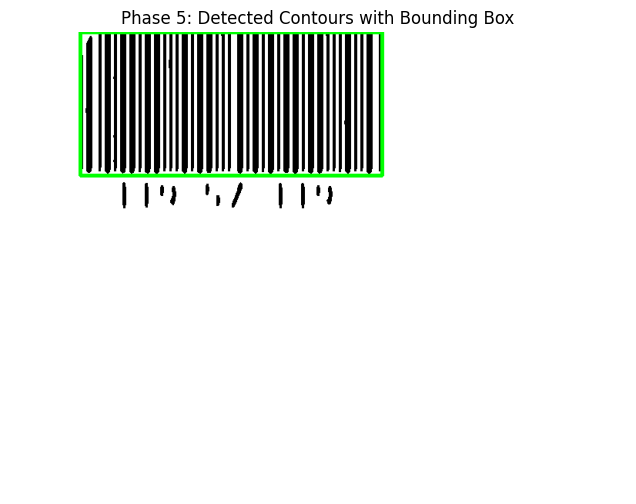

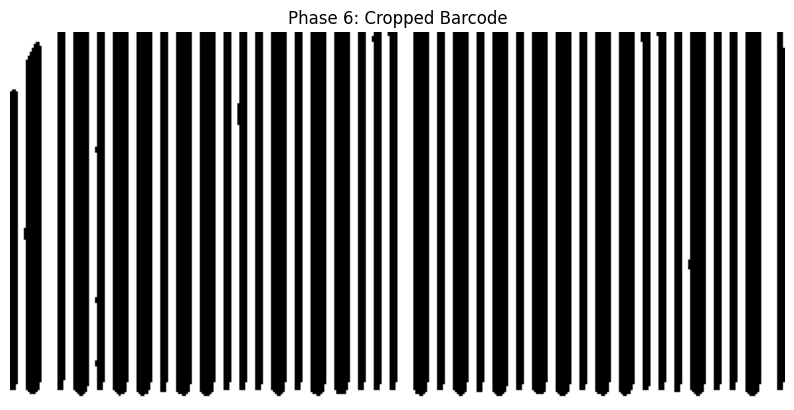

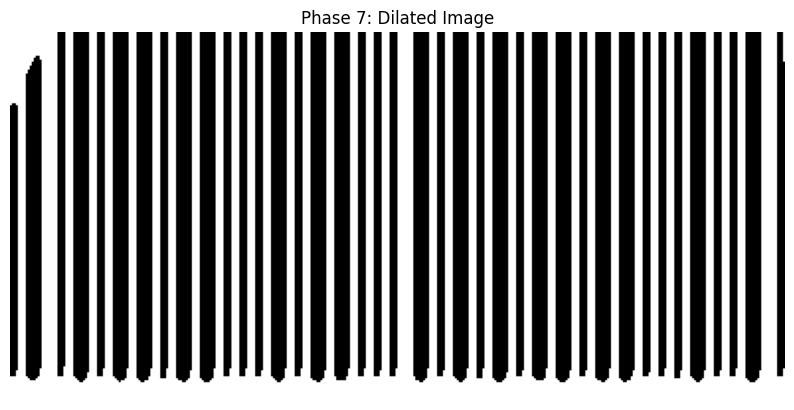

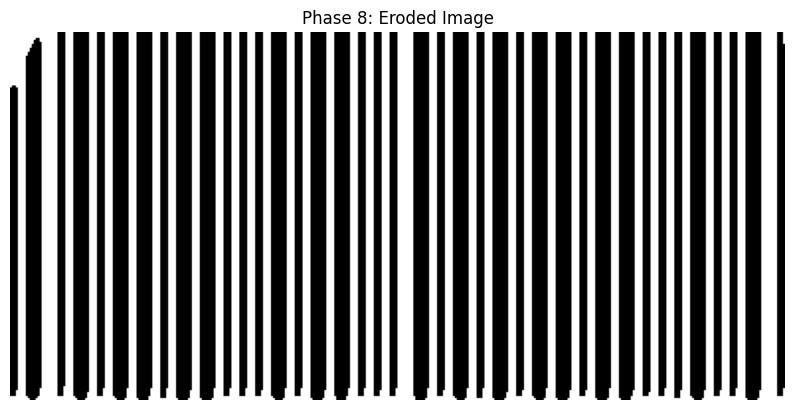

In [ ]:
"""Rotate the image by a specified angle."""
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return rotated

"""Detect the rotation angle using Hough Transform."""
def detect_rotation_angle(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Edge detection
    edges = cv2.Canny(blurred, 200, 250)
    plot_images(edges,"Edges")

    # Detect lines using Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)

    if lines is not None:
        rho, theta = lines[0][0]
        angle = np.degrees(theta)  # Convert the angle to degrees
        print(f"Detected Angle: {180-angle}")

        # Adjust the angle to horizontal
        if 90 < angle <= 180:
            adjusted_angle = angle - 180
        elif 0 <= angle <= 90:
            adjusted_angle = angle

        print(f"Adjusted Angle: {adjusted_angle}")
        return adjusted_angle
    return 0  # Return 0 if no angle is detected

# Load the image
# image_path = f"{omarVar}/Test Cases/09 - e3del el soora ya3ammm.jpg"
image_path = f"{maeenVar}/Test Cases/09 - e3del el soora ya3ammm.jpg"
# Extreme Versions of Test Case 9
# image_path = f"{maeenVar}/Test Cases/09 - e3del el soora ya3ammm2.jpg"
# image_path = f"{maeenVar}/Test Cases/09 - e3del el soora ya3ammm3.jpg"
# image_path = f"{maeenVar}/Test Cases/09 - e3del el soora ya3ammm4.jpg"

image = cv2.imread(image_path)

# Step 1: Detect the rotation angle
angle = detect_rotation_angle(image)
print(f"Detected rotation angle: {angle} degrees")

# Step 2: Rotate the image
rotated_image = rotate_image(image, angle)
plot_images(rotated_image,"Rotated Image")
rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.medianBlur(cv2.blur(rotated_image, (2,15)), 5)
plot_images(blurred_image, "Blurred")
_, image_threshold = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_images(image_threshold,"Thresholded Image")

# Step 3: Crop the barcode
cropped_barcode = crop_barcode(image_threshold, "09 - e3del el soora ya3ammm")

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
dilated_image = cv2.dilate(cropped_barcode, kernel, iterations=1)
plot_images(dilated_image,"Phase 7: Dilated Image")
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 200)) # Using 1x200 structuring element because the bar height is 200px,
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
plot_images(eroded_image,"Phase 8: Eroded Image")
# save_path = f"{maeenVar}/Output/09 - e3del el soora ya3ammm_cropped_eroded_barcode.jpg"
# cv2.imwrite(save_path, eroded_image)

## **TC 10: Recognize Bad Contrast Image Barcode**

In [ ]:
def histogram_stretching(image):
    # Create a figure with 2 subplots for the images and histograms
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Display the original image
    plot_images_fig(image,axes[0,0],"Original Image")

    # Plot the histogram of the original image
    plot_histogram(image, axes[1, 0], "Histogram of Original Image")

    # Stretching Histogram by setting a threshold at middle of the histrogram
    image[image < 127] = 0
    image[image >= 127] = 255

    # Display the stretched image
    plot_images_fig(image,axes[0,1],"Stretched Image")

    # Plot the histogram of the stretched image
    plot_histogram(image, axes[1, 1], "Histogram of Stretched Image")

    # Display the plots
    plt.tight_layout()
    plt.show()

    return image

# Path to your image
image_path = f"{maeenVar}/Test Cases/05 - meen taffa el nour!!!.jpg"
# image_path = f"{omarVar}/Test Cases/10 - wen el kontraastttt.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply histogram stretching
stretched_image = histogram_stretching(image)

# cropped_stretched_image = crop_barcode(stretched_image,"10 - wen el kontraastttt")

# # Save the adjusted image
# save_path = f"{maeenVar}/Output/10 - wen el kontraastttt.jpg"
# save_path = f"{omarVar}/Output/10 - wen el kontraastttt.jpg"
# cv2.imwrite(save_path, cropped_stretched_image)

## **Read Barcode**

In [ ]:
def read_barcode(image_name):
  # 0 means narrow, 1 means wide
  NARROW = "0"
  WIDE = "1"
  code11_widths = {
      "00110": "Stop/Start",
      "10001": "1",
      "01001": "2",
      "11000": "3",
      "00101": "4",
      "10100": "5",
      "01100": "6",
      "00011": "7",
      "10010": "8",
      "10000": "9",
      "00001": "0",
      "00100": "-",
  }

  image_path = f"{omarVar}/Output/{image_name}_cropped_eroded_barcode.jpg"
  # image_path = f"{maeenVar}/Output/{image_name}_cropped_eroded_barcode.jpg"
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  # Apply adaptive thresholding
  image_binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

  # Find contours to get the barcode elements (bars)
  contours, _ = cv2.findContours(image_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Extract the widths of the barcode bars
  bar_widths = []
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      if h > 10:  # Avoid small noise contours
          bar_widths.append(w)

  # Analyze bar widths (e.g., narrow bar size)
  narrow_bar_size = np.median(bar_widths)  # Use median to avoid outliers
  # print(bar_widths)
  # Get the average of each column in your image
  mean = image.mean(axis=0)

  # Set a threshold based on the mean intensity of the image. We use narrow_bar_size as a guide.
  threshold = math.ceil(np.median(mean)) + 10

  # Set it to black or white based on its value
  mean[mean <= threshold] = 1
  mean[mean > threshold] = 0

  # Convert to string of pixels in order to loop over it
  pixels = ''.join(mean.astype(np.uint8).astype(str))
  # print(pixels)
  # Need to figure out how many pixels represent a narrow bar
  narrow_bar_size = 0
  for pixel in pixels:
      if pixel == "1":
          narrow_bar_size += 1
      else:
          break

  wide_bar_size = narrow_bar_size * 2

  digits = []
  pixel_index = 0
  current_digit_widths = ""
  skip_next = False

  while pixel_index < len(pixels):

      if skip_next:
          pixel_index += narrow_bar_size
          skip_next = False
          continue

      count = 1
      try:
          while pixels[pixel_index] == pixels[pixel_index + 1]:
              count += 1
              pixel_index += 1
      except:
          pass
      pixel_index += 1

      current_digit_widths += NARROW if count == narrow_bar_size else WIDE

      if current_digit_widths in code11_widths:
          digits.append(code11_widths[current_digit_widths])
          current_digit_widths = ""
          skip_next = True  # Next iteration will be a separator, so skip it

  print(digits)

# Generic Barcode Decoder

In [ ]:
def check_low_contrast(image, threshold=.2):
    """
      Steps Made:
      - Adjust image contrast if below threshold.
      - Get the minimum pixel intensity.
      - Get the maximum pixel intensity.
      - Calculate Michelson contrast.
      - Enhance contrast if it is below the threshold.
      - Return the adjusted or original image.
    """
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    michelson_contrast = (max_intensity - min_intensity) / (max_intensity + min_intensity)
    if michelson_contrast < threshold:
        # Image is low contrast, stretching hisogram
        image = histogram_stretching(image)
    return image

def histogram_stretching(image):
    # Create a figure with 2 subplots for the images and histograms
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # Display the original image
    plot_images_fig(image,axes[0,0],"Original Image")

    # Plot the histogram of the original image
    plot_histogram(image, axes[1, 0], "Histogram of Original Image")

    # Stretching Histogram by setting a threshold at middle of the histrogram
    image[image < 127] = 0
    image[image >= 127] = 255

    # Display the stretched image
    plot_images_fig(image,axes[0,1],"Stretched Image")

    # Plot the histogram of the stretched image
    plot_histogram(image, axes[1, 1], "Histogram of Stretched Image")

    # Display the plots
    plt.tight_layout()
    plt.show()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

#########################################################################

def check_shifted_histogram(image):
    # Calculate histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel()
    hist_normalized = hist / hist.sum()

    # Calculate mean intensity
    mean_intensity = np.sum(np.arange(256) * hist_normalized)

    print(f"Mean Intensity: {mean_intensity}")

    # Check for dark or bright images
    if (mean_intensity < 15) | (mean_intensity > 245):  # Threshold for darkness/brightness
      image = shift_histogram_to_middle(image)

    return image

def shift_histogram_to_middle(image):
  # Get histogram midpoint
  """
    Steps Made:
    - Calculate histogram
    - Left non-zero pixel intensity
    - Right non-zero pixel intensity
    - Midpoint
    - Shift by midpoint of the histogram
    - Shift the pixel values by the calculated amount
    - Clip the values to be within the valid range [0, 255]
  """
  left, right, midpoint = calculate_histogram_midpoint(image)
  mean_val = np.mean(image)
  # Shift by midpoint of the histogram
  shift_value = 127 - math.floor((mean_val + midpoint)/2)

  # Shift the pixel values by the calculated amount
  shifted_image = image + shift_value

  # Clip the values to be within the valid range [0, 255]
  shifted_image = np.clip(shifted_image, 0, 255).astype(np.uint8)

  fig, axes = plt.subplots(2, 2, figsize=(20, 10))
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  # Plot original image
  plot_images_fig(image,axes[0,0],"Original Image")
  # Plot original histogram
  plot_histogram(image, axes[1,0], "Histogram of Original Image")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  shifted_image = cv2.cvtColor(shifted_image, cv2.COLOR_GRAY2BGR)
  # Plot shifted image
  plot_images_fig(shifted_image,axes[0,1],"Shifted Image")
  # Plot shifted image histogram
  plot_histogram(shifted_image, axes[1, 1], "Histogram of Shifted Image")
  shifted_image = cv2.cvtColor(shifted_image, cv2.COLOR_BGR2GRAY)

  return shifted_image

def calculate_histogram_midpoint(image):
    # Calculate the histogram of the image (grayscale)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel()

    # Find the first non-zero intensity from the left
    left = np.argmax(hist > 0)

    # Find the first non-zero intensity from the right
    right = len(hist) - 1 - np.argmax(hist[::-1] > 0)

    # Calculate the midpoint
    midpoint = (left + right) // 2
    return left, right, midpoint

#########################################################################

def check_blurred(image, threshold=5.0, kernel_size=(5, 5)):
    # Step 1: Apply an average filter (smoothing)
    blurred_image = cv2.blur(image, kernel_size)

    # Step 2: Compute the absolute difference between the original and blurred image
    difference = cv2.absdiff(image, blurred_image)

    # Step 3: Compute the mean of the difference
    mean_difference = np.mean(difference)
    print(f"Mean Difference: {mean_difference}")

    # Step 4: Compare the mean difference with the threshold
    if mean_difference < threshold and mean_difference > 1:
      plot_images(image,"Original Image")
      image = sharpen_image(image)
      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Adjust kernel size if needed
      eroded_image = cv2.erode(image, kernel, iterations=1)
      plot_images(eroded_image,"Eroded Image")
      return eroded_image

    # Step 5: Return non-blured image
    return image

# Function to sharpen an image
def sharpen_image(image):
    # Step 1: Apply the Laplacian filter
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Step 2: Convert Laplacian back to the same data type as the original image
    laplacian = np.uint8(np.absolute(laplacian))

    # Step 3: Sharpen by adding the Laplacian to the original image
    alpha = 2 # Weight multiplied by original image
    beta = -2 # Weight multiplied by laplacian image
    sharpened = cv2.addWeighted(image, alpha, laplacian, beta, 0)

    return sharpened

#########################################################################

# Function to check for salt-and-pepper noise
def check_salt_and_pepper(image):
    # 1. Apply a median filter to smooth the image
    median_filtered = cv2.medianBlur(image, 3)  # 3x3 kernel

    # 2. Calculate the difference between original and median-filtered image
    difference = cv2.absdiff(image, median_filtered)

    # 3. Threshold the difference to identify potential noise pixels
    noise_pixels = np.sum(difference > 30)  # Threshold > 30 to focus on significant changes
    total_pixels = image.size
    noise_ratio = (noise_pixels / total_pixels) * 100

    # 5. Decision
    print(f"Noise Ratio: {noise_ratio:.2f}%")
    if noise_ratio > 2:  # Threshold for significant noise
        # Display results
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        plot_images_fig(image,axes[0,0],"Original Image")
        plot_histogram(image, axes[0,1], "Histogram of Original Image")
        plot_images_fig(difference, axes[1,0], "Difference (Noise Map)")
        plot_histogram(difference, axes[1,1], "Histogram of Difference")
        return remove_salt_and_pepper(image)
    return image

def remove_salt_and_pepper(image):
  # Apply a blur (15) to reduce small noise, preserving key details.
  # Use a median filter (7) since the space between bars is 8 pixels, preserving bar structure while removing noise.
  blur_image = cv2.blur(image, (1,15)) # Vertical kernel
  plot_images(blur_image,"Blurred Image")
  Filtered_Image = cv2.medianBlur(blur_image, 7)
  plot_images(Filtered_Image,"Filtered Image")
  _, image_threshold = cv2.threshold(Filtered_Image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  plot_images(image_threshold,"Thresholded Image")
  return image_threshold

#########################################################################

"""Rotate the image by a specified angle."""
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return rotated

"""Detect the rotation angle using Hough Transform."""
def detect_rotation_angle(image):

    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Edge detection
    edges = cv2.Canny(blurred, 200, 250)
    plot_images(edges,"Edges")
    # Detect lines using Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)

    if lines is not None:
        rho, theta = lines[0][0]
        angle = np.degrees(theta)  # Convert the angle to degrees
        print(f"Detected Angle: {angle}")

        if angle == 0:
          return image

        # Adjust the angle to horizontal
        if 90 < angle <= 180:
            adjusted_angle = angle - 180
        elif 0 <= angle <= 90:
            adjusted_angle = angle

        print(f"Adjusted Angle: {adjusted_angle}")
        gray_image_3ch = cv2.merge([image, image, image])
        rotated_image = rotate_image(gray_image_3ch, adjusted_angle)
        rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
        blurred_image = cv2.medianBlur(cv2.blur(rotated_image, (1,15)), 7)
        plot_images(blurred_image, "Blurred")
        _, image_threshold = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plot_images(image_threshold,"Thresholded Image")
        return image_threshold

    return image

#########################################################################

def enhance_barcode(cropped_barcode):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
  dilated_image = cv2.dilate(cropped_barcode, kernel, iterations=1)
  plot_images(dilated_image,"Phase 7: Dilated Image")
  # Using 1x200 structuring element because the bar code height is 200px, so the filter covers all the bar
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 200))
  eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
  plot_images(eroded_image,"Phase 8: Eroded Image")
  return eroded_image

#########################################################################

def get_image_name(case_number):
    # Mapping of case numbers to image names
    cases = {
        1:  "01 - lol easy",
        2:  "02 - still easy",
        3:  "03 - eda ya3am ew3a soba3ak mathazarsh",
        4:  "04 - fen el nadara",
        5:  "05 - meen taffa el nour!!!",
        6:  "06 - meen fata7 el nour 333eenaaayy",
        7:  "07 - mal7 w felfel",
        8:  "08 - compresso espresso",
        9:  "09 - e3del el soora ya3ammm",
        10: "10 - wen el kontraastttt",
        11: "11 - bayza 5ales di bsara7a"
    }

    # Get the image name, or return None if case_number is not valid
    return cases.get(case_number, "Invalid case number")

current_testcases = [1, 2, 4, 5, 6, 7, 9, 10]

for i in current_testcases:
  print(f"Test Case: {i}")
  image_name = get_image_name(i) # Enter Test Case Number 1-11
  image_path = f"{maeenVar}/Test Cases/{image_name}.jpg"
  # image_path = f"{omarVar}/Test Cases/{image_name}.jpg"
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Check for Salt/Pepper Images
  image = check_salt_and_pepper(image)

  # Check for rotation in Images
  image = detect_rotation_angle(image)

  # Check for Dark/Bright Images
  image = check_shifted_histogram(image)

  # Check for low contrast using Michelson Contrast
  image = check_low_contrast(image)

  # Check for blurred Images
  image = check_blurred(image, threshold=5.0, kernel_size=(5, 5))

  # Crop Barcode
  image = crop_barcode(image,image_name)
  image = enhance_barcode(image)
  save_path = f"{maeenVar}/Output/{image_name}_cropped_eroded_barcode.jpg"
  # save_path = f"{omarVar}/Output/{image_name}_cropped_eroded_barcode.jpg"
  # cv2.imwrite(save_path, image)
  read_barcode(image_name)